# Modelling

# I.Importing packages 

In [0]:
from glob import glob
import os 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import cm
from tqdm import tqdm
from cv2 import imread, resize, INTER_AREA, cvtColor, applyColorMap, COLOR_BGR2RGB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# custom functions 
import seaborn as sns 
import pandas as pd 

# from keras 
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image 
from keras.applications import  Xception, InceptionResNetV2, InceptionV3
from keras.layers import  Dense, BatchNormalization, Activation, Dropout
from keras.models import  Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# II. Defining Helper Functions 
## A. Reading in & Modifying images

In [0]:
def load_dataset(path):
    """
    Reads in the path of each images belonging to the different 
    datasets and then it assignes the correspoinding labels to them. 
    
    Returns 2 numpy arrays one containing file paths to images, 
    and one containing onehot-encoded classification labels.
    """
    # NORMAL 
    files_normal = glob(os.path.join(path, "NORMAL", "*.jpeg"))
    size_normal = len(files_normal)
    label_normal = [0] * size_normal
    
    # PNEUMONIA
    files_pneumonia = glob(os.path.join(path, "PNEUMONIA", "*.jpeg"))
    size_pneumonia = len(files_pneumonia)
    label_pneumonia = [1] * size_pneumonia

    # merge each label + file from the categories into one array
    labels = np.array(label_normal + label_pneumonia)
    files = np.array(files_normal + files_pneumonia)
    
    return files, labels



def cmap(cmap_name):
    """
    Extracts a matplotlib colormap color 
    information as a LUT compatible with cv2.applyColormap().
    
    Returns a colormap. 
    """
    c_map = cm.get_cmap(cmap_name, 256)
    rgba_data = cm.ScalarMappable(cmap=c_map).to_rgba(np.arange(0, 1.0, 1.0 / 256.0), bytes=True)
    rgba_data = rgba_data[:, 0:-1].reshape((256, 1, 3))

    # Convert to BGR, uint8, for OpenCV.
    cmap = np.zeros((256, 1, 3), np.uint8)
    cmap[:, :, :] = rgba_data[:, :, ::-1]

    return cmap


def path_to_tensor(img_path):
    """
    Colorize the image after reading it in 
    from the given path and then it makes a 4D tensor from it. 
    
    Returns the 4D tensors of the colorized image. 
    """ 
    dim = (width, height)
    img_gray = imread(img_path)
    img_resized = resize(img_gray, dim, interpolation = INTER_AREA)
    img_color =  cvtColor(applyColorMap(img_resized, cmap('terrain')),COLOR_BGR2RGB)
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) 
    return np.expand_dims(img_color, axis=0)

def paths_to_tensor(img_paths):
    """
    Makes a list of tensors from the 4D tensors 
    we created in the previous step. 
    
    Returns a list of 4D tensors of colorized images. 
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)           


## B. Evalatuing the model's performance 

In [0]:
def plot_loss_history(history):
    """
    Plots historical information about training 
    and validation loss. 
    
    Returns a plot. 
    """
    loss_df = pd.DataFrame({'epoch': [x + 1 for x in range(len(history.history['loss']))],
                            'train_loss': history.history['loss'], 
                            'val_loss':history.history['val_loss']})

    df = loss_df.melt('epoch', var_name='cols',  value_name='vals')
    sns.set_context("talk", rc={"lines.linewidth": 1.2})
    sns.set_style("ticks")
    ax = sns.factorplot(x="epoch", y="vals", hue='cols', data=df, legend=False, palette='Reds', size=5, aspect = 1.5 )
    ax.set(xlabel='Epoch', ylabel='Loss', title = "Changing of loss values per epoch"  )
    plt.legend(loc='best')
    plt.show()

def predict_test_set(model):
    '''
    Predicts on the test set. 
  
    Returns predictions. 
    '''
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors/255]
    return predictions

def evaluate_model(target, predictions):
    """
    Prints the confusion matrix and 
    calculates the precision and recall.
    
    Returns precision and recall values and 
    prints the confusion matrix. 
    """
    
    target = list(target)
    
    # calculate precision + recall 
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    F1 = f1_score(target, predictions, average='weighted')  
    AUC = roc_auc_score(target, predictions)

    print('Precision:',precision.round(2))
    print('Recall:',recall.round(2))
    print('F1 Score:',F1.round(2))
    print('AUC:',AUC.round(4))
    
    # create confusion matrix
    
    classes=['NORMAL', 'PNEUNOMIA']
    cm = confusion_matrix(target, predictions)
    cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
    
   # sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(3,3))
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'Reds', cbar=False, ax = ax)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation =0)
    ax.set(xlabel='Predicted label', ylabel='True label', title = "Confusion Matrix on the test set"  )
    plt.show()
    

# III. Settings 

##1. Check if there is avaliable GPU

In [0]:
# check if we have avaliable GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##2.Mounting  Google Drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Capstone/chest_xray"

test  train  val


# IV. Importing & Preprocessing Images 

## 1. Importing images 

### Collect the paths to images

In [0]:
# paths to different datasets 
folder = '/content/drive/My Drive/Capstone/chest_xray'
train_path = os.path.abspath(os.path.join(folder, 'train'))
test_path =  os.path.abspath(os.path.join(folder, 'test'))
valid_path =  os.path.abspath(os.path.join(folder, 'val'))

# helper function to read in data from the given path 

train_files, train_targets = load_dataset(train_path)
test_files, test_targets  = load_dataset(test_path)
valid_files, valid_targets  = load_dataset(valid_path)

print('Reading in the paths to each image is done.')

Reading in the paths to each image is done.


## 2. Preprocessing the images 

### Coloring & resizing 

In [0]:
# setting the width and height of the images 
width, height = 150,150

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(valid_files).astype('float32')
test_tensors = paths_to_tensor(test_files).astype('float32')

# one-hot encoding the targets 
train_target = to_categorical(train_targets,2)    
test_target = to_categorical(test_targets,2)    
valid_target = to_categorical(valid_targets,2) 


print('There are %d images in the train set.'% len(train_tensors))
print('There are %d images in the test set.'% len(valid_tensors))
print('There are %d images in the validation set.'% len(test_tensors))

100%|██████████| 624/624 [03:55<00:00,  3.46it/s]

There are 5216 images in the train set.
There are 16 images in the test set.
There are 624 images in the validation set.


##3. Image Generator for Image Augmentation

In [0]:
img_generator = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.05,
                                         height_shift_range=0.05,
                                         zoom_range=0.2, 
                                         fill_mode = 'nearest',
                                         rescale=1./ 255)

# IV. Modelling  - Transfer Learning 

## 1. Helper funtions for modelling 

In [0]:
def train_model(model, layer_nbr, epochs, batch_size, optimizer, checkpoint_path):
  
  """
  Trains the model with real-time data augmentation. 
  
  Returns the history of the model training process. 
  
  """
  # Freeze the first x layers and unfreeze the rest
  
  for layer in model.layers[:layer_nbr]:
      layer.trainable = False
  for layer in model.layers[layer_nbr:]:
      layer.trainable = True

  
  # compile the model 
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #SGD(lr=0.0001, momentum=0.9),

  # Early Stopping 
  early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
  
  # Setting checkpointer 
  file_path = '/content/drive/My Drive/Capstone/saved_models/' + checkpoint_path
  checkpoint =  ModelCheckpoint(filepath=file_path, 
                               verbose = 1, 
                               save_best_only=True) 
  
  # reduce learning rate 
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, 
                                factor=0.1, patience=1, min_lr=5.00e-08)
  

  
  # Training the model 
  history = model.fit_generator(generator = img_generator.flow(train_tensors, train_target, 
                                                                 batch_size = batch_size,
                                                                 seed = 1234), 
                                  steps_per_epoch = len(train_tensors) // batch_size, 
                                  epochs = epochs,
                                  initial_epoch = 0, 
                                  validation_data = (test_tensors/255, test_target),   
                                  validation_steps = len(test_tensors) //  batch_size,
                                  callbacks = [early_stop, checkpoint, reduce_lr],
                                  shuffle = True)
    

  return history 


def train_diff_layer_sizes(training_dict, base_model, epochs, batch_size, optimizer):
  '''
  Trains the given model from the given layer. 
  
  Returns the history of training and validation loss, and the evaluation 
  of the best model (the one that has the smallest validation loss).
  '''
  for key, value in training_dict.items():
    print('Training from layer', key)
  
    layer_nbr = key 
    checkpoint_path = value
	
  	# Adding custom Layers to the model
    a = base_model.output
    a = Dropout(0.5)(a)
    a = BatchNormalization()(a)
    predictions_v1 = Dense(2, activation="sigmoid")(a)
  
  	# Creating the final model 
    model = Model(input = base_model.input, output = predictions_v1)
    
    # Training the model 
    history = train_model(model, layer_nbr, epochs, batch_size, optimizer, checkpoint_path)
  
    ## plot loss history 
    plot_loss_history(history)
  
    ### evaluating the model 
    ## Load weights
    model.load_weights('/content/drive/My Drive/Capstone/saved_models/' + checkpoint_path)
  
    # Predict on test set
    pred = predict_test_set(model)
  
    # Evaluate the model
    evaluate_model(test_targets,pred)
    
    

## 2 . Finding out how many layers to train per each architecture 

### Setting batch_size, epochs  and optimizer



In [0]:
batch_size = 128
epochs = 100
optimizer = 'adam'

## Xception

In [0]:
# loading the pre-built model
base_model_xception = Xception(include_top = False, weights = "imagenet", input_shape = (width, height, 3), pooling= 'max')

# Get the number of layers in the model 
print("Number of layers in the model:",len(base_model_xception.layers))

83689472/83683744 [==============================] - 1s 0us/step
Number of layers in the model: 133


In [0]:
for i, layer in enumerate(base_model_xception.layers):
  print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [0]:
training_dict_xception = {
  0:  'best_weights_xception.h5' ,
	75:  'best_weights_xception_75.h5' ,
	95:  'best_weights_xception_95.h5' ,
	115: 'best_weights_xception_115.h5' 
}

In [0]:
for key, value in training_dict_xception.items():
  print(str(value))

best_weights_xception.h5
best_weights_xception_75.h5
best_weights_xception_95.h5
best_weights_xception_115.h5


Training from layer 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
40/40 [==============================] - 110s 3s/step - loss: 0.2437 - acc: 0.9156 - val_loss: 3.2190 - val_acc: 0.7484

Epoch 00001: val_loss improved from inf to 3.21903, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception.h5
Epoch 2/100
40/40 [==============================] - 92s 2s/step - loss: 0.0986 - acc: 0.9647 - val_loss: 0.4068 - val_acc: 0.9087

Epoch 00002: val_loss improved from 3.21903 to 0.40676, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception.h5
Epoch 3/100
40/40 [==============================] - 88s 2s/step - loss: 0.1056 - acc: 0.9606 - val_loss: 1.4916 - val_acc: 0.7780

Epoch 00003: val_loss did not improve from 0.40676

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 87s 2s/step - loss: 0.0622 - acc: 0.9811 - val_loss: 0.2894 - val_acc: 0.9175

Epoch 00004: val_loss improved from 0.40676 to 0.28942, 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


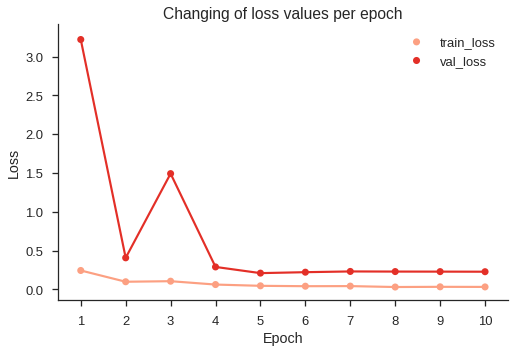

Precision: 0.92
Recall: 0.97
F1 Score: 0.93
AUC: 0.9171


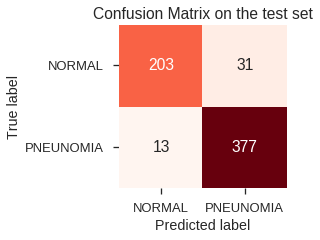

Training from layer 75
Epoch 1/100
40/40 [==============================] - 51s 1s/step - loss: 0.0780 - acc: 0.9747 - val_loss: 0.8337 - val_acc: 0.8950

Epoch 00001: val_loss improved from inf to 0.83366, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_75.h5
Epoch 2/100
40/40 [==============================] - 41s 1s/step - loss: 0.0359 - acc: 0.9911 - val_loss: 0.3769 - val_acc: 0.9359

Epoch 00002: val_loss improved from 0.83366 to 0.37687, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_75.h5
Epoch 3/100
40/40 [==============================] - 41s 1s/step - loss: 0.0242 - acc: 0.9918 - val_loss: 0.5875 - val_acc: 0.9127

Epoch 00003: val_loss did not improve from 0.37687

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 41s 1s/step - loss: 0.0344 - acc: 0.9891 - val_loss: 0.3386 - val_acc: 0.9279

Epoch 00004: val_loss improv

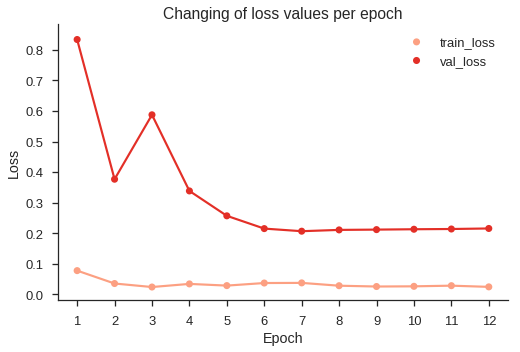

Precision: 0.93
Recall: 0.96
F1 Score: 0.93
AUC: 0.9201


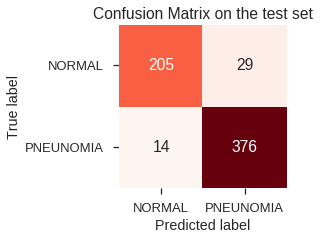

Training from layer 95
Epoch 1/100
40/40 [==============================] - 44s 1s/step - loss: 0.0870 - acc: 0.9637 - val_loss: 0.5190 - val_acc: 0.9175

Epoch 00001: val_loss improved from inf to 0.51896, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_95.h5
Epoch 2/100
40/40 [==============================] - 36s 907ms/step - loss: 0.0164 - acc: 0.9949 - val_loss: 0.3911 - val_acc: 0.9327

Epoch 00002: val_loss improved from 0.51896 to 0.39111, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_95.h5
Epoch 3/100
40/40 [==============================] - 40s 1s/step - loss: 0.0166 - acc: 0.9946 - val_loss: 0.3959 - val_acc: 0.9295

Epoch 00003: val_loss did not improve from 0.39111

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 38s 961ms/step - loss: 0.0291 - acc: 0.9906 - val_loss: 0.2878 - val_acc: 0.9311

Epoch 00004: val_loss 

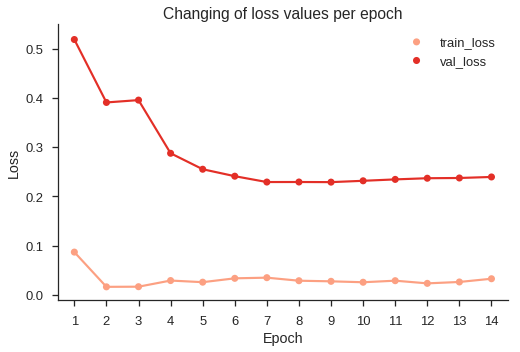

Precision: 0.91
Recall: 0.97
F1 Score: 0.92
AUC: 0.9026


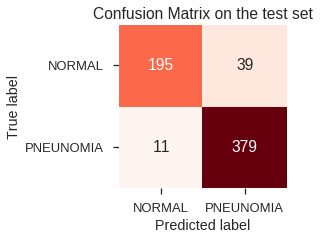

Training from layer 115
Epoch 1/100
40/40 [==============================] - 41s 1s/step - loss: 0.0771 - acc: 0.9761 - val_loss: 0.3113 - val_acc: 0.9343

Epoch 00001: val_loss improved from inf to 0.31127, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_115.h5
Epoch 2/100
40/40 [==============================] - 34s 854ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 0.2790 - val_acc: 0.9279

Epoch 00002: val_loss improved from 0.31127 to 0.27901, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_115.h5
Epoch 3/100
40/40 [==============================] - 36s 903ms/step - loss: 0.0091 - acc: 0.9970 - val_loss: 0.2782 - val_acc: 0.9207

Epoch 00003: val_loss improved from 0.27901 to 0.27824, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_xception_115.h5
Epoch 4/100
40/40 [==============================] - 37s 927ms/step - loss: 0.0324 - acc: 0.9891 - val_loss: 0.3064 - val_acc: 0.9279

Ep

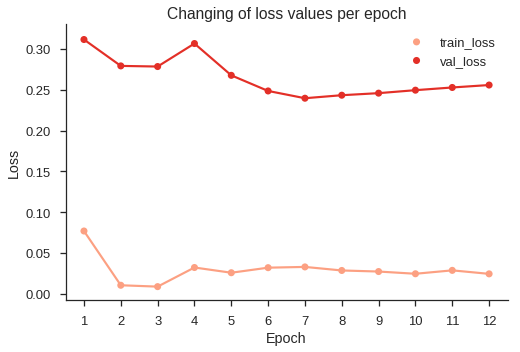

Precision: 0.9
Recall: 0.98
F1 Score: 0.92
AUC: 0.8979


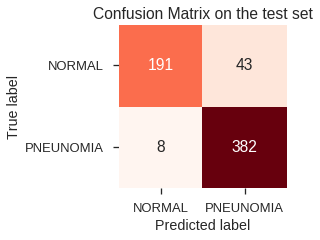

In [0]:
train_diff_layer_sizes(training_dict_xception, base_model_xception, epochs, batch_size, optimizer)

## InceptionResNetV2

In [0]:
# loading the pre-built model
base_model_incep_resnet = InceptionResNetV2(include_top = False, weights = "imagenet", input_shape = (width, height, 3), pooling= 'max')

# Get the number of layers in the model 
print("Number of layers in the model:",len(base_model_incep_resnet.layers))

219062272/219055592 [==============================] - 3s 0us/step
Number of layers in the model: 781


In [0]:
for i, layer in enumerate(base_model_incep_resnet.layers):
  print(i, layer.name)

0 input_2
1 conv2d_5
2 batch_normalization_9
3 activation_1
4 conv2d_6
5 batch_normalization_10
6 activation_2
7 conv2d_7
8 batch_normalization_11
9 activation_3
10 max_pooling2d_1
11 conv2d_8
12 batch_normalization_12
13 activation_4
14 conv2d_9
15 batch_normalization_13
16 activation_5
17 max_pooling2d_2
18 conv2d_13
19 batch_normalization_17
20 activation_9
21 conv2d_11
22 conv2d_14
23 batch_normalization_15
24 batch_normalization_18
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_10
29 conv2d_12
30 conv2d_15
31 conv2d_16
32 batch_normalization_14
33 batch_normalization_16
34 batch_normalization_19
35 batch_normalization_20
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_20
42 batch_normalization_24
43 activation_16
44 conv2d_18
45 conv2d_21
46 batch_normalization_22
47 batch_normalization_25
48 activation_14
49 activation_17
50 conv2d_17
51 conv2d_19
52 conv2d_22
53 batch_normalization_21
54 batch_normalization_23
55 batch_n

In [0]:
training_dict_incep_resnet = {
      0:   'best_weights_incep_resnet.h5' 
    , 59:  'best_weights_incep_resnet_59.h5'
    , 287: 'best_weights_incep_resnet_287.h5' 
    , 630: 'best_weights_incep_resnet_630.h5' 
}


Training from layer 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
40/40 [==============================] - 152s 4s/step - loss: 0.2728 - acc: 0.9085 - val_loss: 0.4260 - val_acc: 0.8173

Epoch 00001: val_loss improved from inf to 0.42601, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet.h5
Epoch 2/100
40/40 [==============================] - 98s 2s/step - loss: 0.1314 - acc: 0.9530 - val_loss: 0.5974 - val_acc: 0.8990

Epoch 00002: val_loss did not improve from 0.42601

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
40/40 [==============================] - 94s 2s/step - loss: 0.0912 - acc: 0.9695 - val_loss: 0.1950 - val_acc: 0.9311

Epoch 00003: val_loss improved from 0.42601 to 0.19504, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet.h5
Epoch 4/100
40/40 [==============================] - 95s 2s/step - loss: 0.0700 - acc: 0.9756 - val_loss: 0.1974 - val_acc: 0.9327

Epoch 00004: val_loss did not improve from 0.195

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


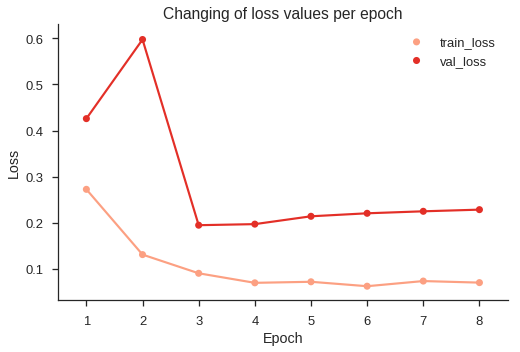

Precision: 0.92
Recall: 0.98
F1 Score: 0.93
AUC: 0.9158


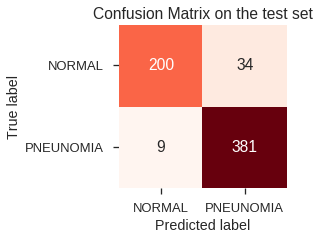

Training from layer 59
Epoch 1/100
40/40 [==============================] - 137s 3s/step - loss: 0.1616 - acc: 0.9437 - val_loss: 9.2408 - val_acc: 0.4183

Epoch 00001: val_loss improved from inf to 9.24078, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_59.h5
Epoch 2/100
40/40 [==============================] - 86s 2s/step - loss: 0.0795 - acc: 0.9743 - val_loss: 5.6451 - val_acc: 0.6034

Epoch 00002: val_loss improved from 9.24078 to 5.64514, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_59.h5
Epoch 3/100
40/40 [==============================] - 86s 2s/step - loss: 0.0753 - acc: 0.9720 - val_loss: 0.4229 - val_acc: 0.9191

Epoch 00003: val_loss improved from 5.64514 to 0.42291, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_59.h5
Epoch 4/100
40/40 [==============================] - 85s 2s/step - loss: 0.0695 - acc: 0.9771 - val_loss: 1.7349 - val_acc: 0.8141

Ep

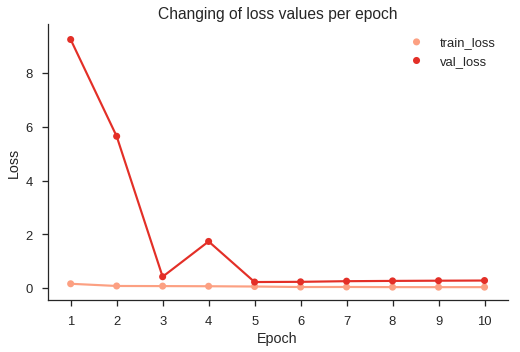

Precision: 0.92
Recall: 0.97
F1 Score: 0.93
AUC: 0.9167


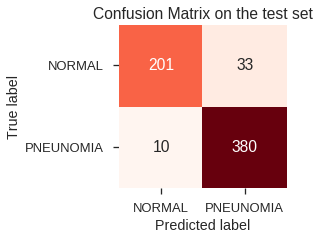

Training from layer 287
Epoch 1/100
40/40 [==============================] - 115s 3s/step - loss: 0.0930 - acc: 0.9680 - val_loss: 1.3823 - val_acc: 0.8526

Epoch 00001: val_loss improved from inf to 1.38227, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_287.h5
Epoch 2/100
40/40 [==============================] - 66s 2s/step - loss: 0.0224 - acc: 0.9920 - val_loss: 0.2592 - val_acc: 0.9135

Epoch 00002: val_loss improved from 1.38227 to 0.25925, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_287.h5
Epoch 3/100
40/40 [==============================] - 67s 2s/step - loss: 0.0254 - acc: 0.9913 - val_loss: 0.3626 - val_acc: 0.8942

Epoch 00003: val_loss did not improve from 0.25925

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 66s 2s/step - loss: 0.0199 - acc: 0.9932 - val_loss: 0.3476 - val_acc: 0.8966

Epoch 00004: val

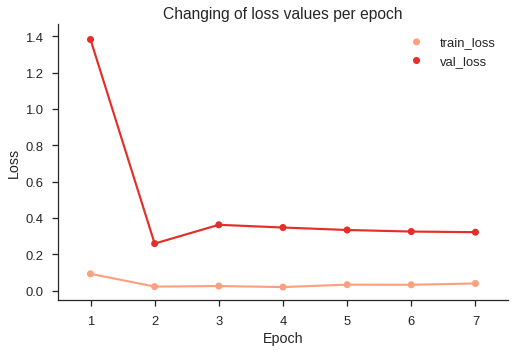

Precision: 0.88
Recall: 0.99
F1 Score: 0.91
AUC: 0.8863


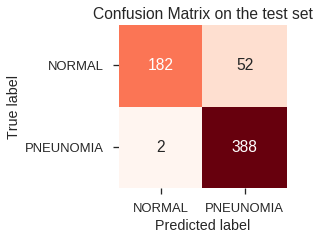

Training from layer 630
Epoch 1/100
40/40 [==============================] - 75s 2s/step - loss: 0.0689 - acc: 0.9742 - val_loss: 0.2374 - val_acc: 0.9127

Epoch 00001: val_loss improved from inf to 0.23738, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_incep_resnet_630.h5
Epoch 2/100
40/40 [==============================] - 34s 845ms/step - loss: 0.0131 - acc: 0.9961 - val_loss: 0.3136 - val_acc: 0.9087

Epoch 00002: val_loss did not improve from 0.23738

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
40/40 [==============================] - 34s 846ms/step - loss: 0.0218 - acc: 0.9925 - val_loss: 0.3255 - val_acc: 0.9095

Epoch 00003: val_loss did not improve from 0.23738

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/100
40/40 [==============================] - 36s 891ms/step - loss: 0.0225 - acc: 0.9912 - val_loss: 0.3327 - val_acc: 0.9095

Epoch 00004: val_loss did 

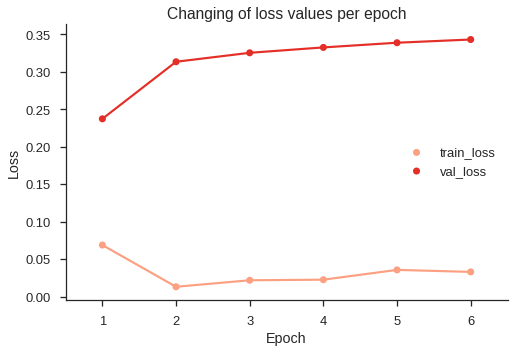

Precision: 0.88
Recall: 0.99
F1 Score: 0.91
AUC: 0.8863


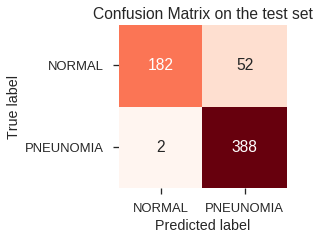

In [0]:
train_diff_layer_sizes(training_dict_incep_resnet, base_model_incep_resnet, epochs, batch_size, optimizer)

## InceptionV3

In [0]:
# loading the pre-built model
base_model_inception = InceptionV3(include_top = False, weights = "imagenet", input_shape = (width, height, 3), pooling= 'max')

# Get the number of layers in the model 
print("Number of layers in the model:",len(base_model_inception.layers))

87916544/87910968 [==============================] - 2s 0us/step
Number of layers in the model: 312


In [0]:
for i, layer in enumerate(base_model_inception.layers):
  print(i, layer.name)

0 input_3
1 conv2d_208
2 batch_normalization_216
3 activation_204
4 conv2d_209
5 batch_normalization_217
6 activation_205
7 conv2d_210
8 batch_normalization_218
9 activation_206
10 max_pooling2d_5
11 conv2d_211
12 batch_normalization_219
13 activation_207
14 conv2d_212
15 batch_normalization_220
16 activation_208
17 max_pooling2d_6
18 conv2d_216
19 batch_normalization_224
20 activation_212
21 conv2d_214
22 conv2d_217
23 batch_normalization_222
24 batch_normalization_225
25 activation_210
26 activation_213
27 average_pooling2d_2
28 conv2d_213
29 conv2d_215
30 conv2d_218
31 conv2d_219
32 batch_normalization_221
33 batch_normalization_223
34 batch_normalization_226
35 batch_normalization_227
36 activation_209
37 activation_211
38 activation_214
39 activation_215
40 mixed0
41 conv2d_223
42 batch_normalization_231
43 activation_219
44 conv2d_221
45 conv2d_224
46 batch_normalization_229
47 batch_normalization_232
48 activation_217
49 activation_220
50 average_pooling2d_3
51 conv2d_220
52 con

In [0]:
training_dict_inception = {
    0:   'best_weights_inception.h5'
	, 40:  'best_weights_inception_40.h5' 
	, 100: 'best_weights_inception_100.h5' 
	, 196: 'best_weights_inception_196.h5' 
	, 279: 'best_weights_inception_279.h5'
}

Training from layer 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
40/40 [==============================] - 91s 2s/step - loss: 0.2541 - acc: 0.9086 - val_loss: 3.6759 - val_acc: 0.6907

Epoch 00001: val_loss improved from inf to 3.67585, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception.h5
Epoch 2/100
40/40 [==============================] - 44s 1s/step - loss: 0.1255 - acc: 0.9552 - val_loss: 1.6988 - val_acc: 0.8245

Epoch 00002: val_loss improved from 3.67585 to 1.69882, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception.h5
Epoch 3/100
40/40 [==============================] - 42s 1s/step - loss: 0.1192 - acc: 0.9612 - val_loss: 0.2980 - val_acc: 0.9271

Epoch 00003: val_loss improved from 1.69882 to 0.29805, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception.h5
Epoch 4/100
40/40 [==============================] - 42s 1s/step - loss: 0.1314 - acc: 0.9625 - val_loss: 2.9829 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


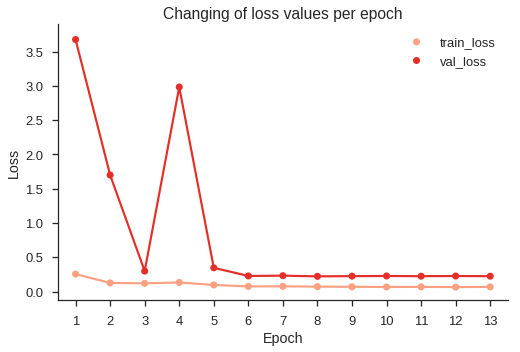

Precision: 0.89
Recall: 0.99
F1 Score: 0.91
AUC: 0.8923


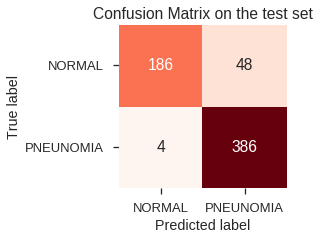

Training from layer 40
Epoch 1/100
40/40 [==============================] - 83s 2s/step - loss: 0.1575 - acc: 0.9436 - val_loss: 2.0949 - val_acc: 0.8061

Epoch 00001: val_loss improved from inf to 2.09494, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_40.h5
Epoch 2/100
40/40 [==============================] - 33s 820ms/step - loss: 0.0789 - acc: 0.9744 - val_loss: 1.8979 - val_acc: 0.8437

Epoch 00002: val_loss improved from 2.09494 to 1.89791, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_40.h5
Epoch 3/100
40/40 [==============================] - 33s 826ms/step - loss: 0.0765 - acc: 0.9704 - val_loss: 3.7439 - val_acc: 0.6939

Epoch 00003: val_loss did not improve from 1.89791

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 33s 821ms/step - loss: 0.0583 - acc: 0.9791 - val_loss: 0.5077 - val_acc: 0.9087

Epoch 00004: val_

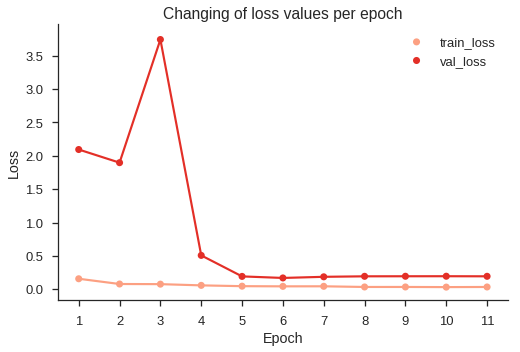

Precision: 0.93
Recall: 0.98
F1 Score: 0.94
AUC: 0.9303


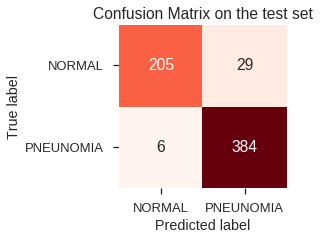

Training from layer 100
Epoch 1/100
40/40 [==============================] - 77s 2s/step - loss: 0.1053 - acc: 0.9619 - val_loss: 0.2901 - val_acc: 0.9295

Epoch 00001: val_loss improved from inf to 0.29012, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_100.h5
Epoch 2/100
40/40 [==============================] - 28s 711ms/step - loss: 0.0355 - acc: 0.9888 - val_loss: 0.2274 - val_acc: 0.9407

Epoch 00002: val_loss improved from 0.29012 to 0.22742, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_100.h5
Epoch 3/100
40/40 [==============================] - 33s 829ms/step - loss: 0.0314 - acc: 0.9896 - val_loss: 0.3068 - val_acc: 0.9215

Epoch 00003: val_loss did not improve from 0.22742

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
40/40 [==============================] - 28s 690ms/step - loss: 0.0230 - acc: 0.9915 - val_loss: 0.2727 - val_acc: 0.9247

Epoch 00004: v

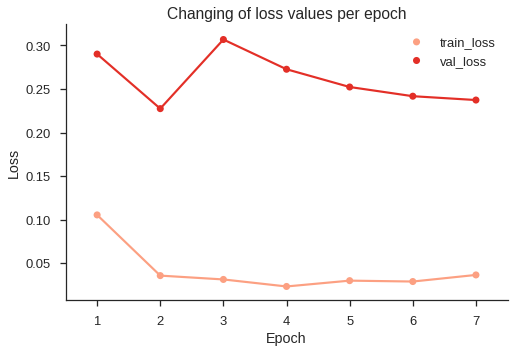

Precision: 0.93
Recall: 0.98
F1 Score: 0.94
AUC: 0.9312


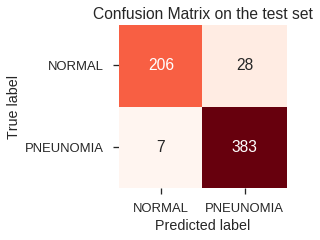

Training from layer 196
Epoch 1/100
40/40 [==============================] - 71s 2s/step - loss: 0.0716 - acc: 0.9724 - val_loss: 0.2996 - val_acc: 0.9287

Epoch 00001: val_loss improved from inf to 0.29961, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_196.h5
Epoch 2/100
40/40 [==============================] - 25s 627ms/step - loss: 0.0163 - acc: 0.9942 - val_loss: 0.3034 - val_acc: 0.9271

Epoch 00002: val_loss did not improve from 0.29961

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
40/40 [==============================] - 25s 622ms/step - loss: 0.0271 - acc: 0.9917 - val_loss: 0.3161 - val_acc: 0.9263

Epoch 00003: val_loss did not improve from 0.29961

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/100
40/40 [==============================] - 30s 744ms/step - loss: 0.0290 - acc: 0.9912 - val_loss: 0.3114 - val_acc: 0.9279

Epoch 00004: val_loss did not

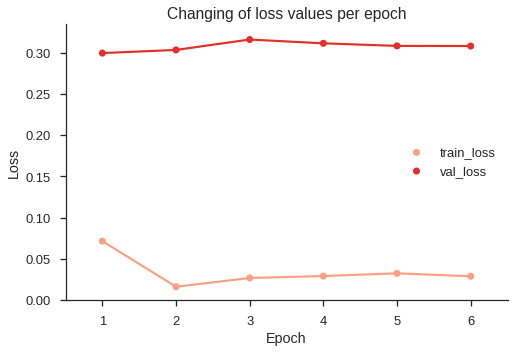

Precision: 0.9
Recall: 0.99
F1 Score: 0.93
AUC: 0.9073


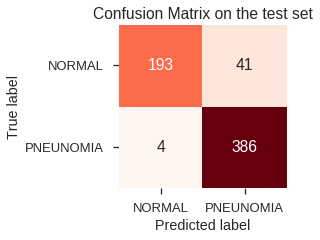

Training from layer 279
Epoch 1/100
40/40 [==============================] - 66s 2s/step - loss: 0.0943 - acc: 0.9583 - val_loss: 0.3306 - val_acc: 0.9255

Epoch 00001: val_loss improved from inf to 0.33060, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_279.h5
Epoch 2/100
40/40 [==============================] - 22s 554ms/step - loss: 0.0175 - acc: 0.9933 - val_loss: 0.3356 - val_acc: 0.9319

Epoch 00002: val_loss did not improve from 0.33060

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
40/40 [==============================] - 22s 551ms/step - loss: 0.0305 - acc: 0.9907 - val_loss: 0.3297 - val_acc: 0.9359

Epoch 00003: val_loss improved from 0.33060 to 0.32974, saving model to /content/drive/My Drive/Capstone/saved_models/best_weights_inception_279.h5
Epoch 4/100
40/40 [==============================] - 27s 671ms/step - loss: 0.0328 - acc: 0.9899 - val_loss: 0.3199 - val_acc: 0.9367

Epoch 00004: v

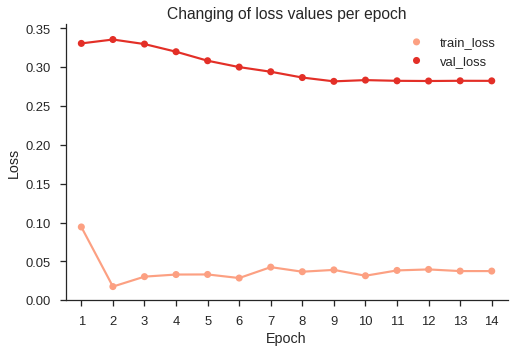

Precision: 0.92
Recall: 0.99
F1 Score: 0.94
AUC: 0.9231


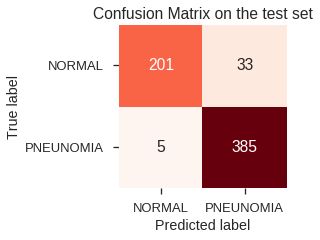

In [0]:
train_diff_layer_sizes(training_dict_inception, base_model_inception, epochs, batch_size, optimizer)